# User_antenna mapping
La idea es crear la lista que cuenta antennas utilizadas para cada user en el dataset outputeado por simple_format diariamente y agrupar esta lista (con repeticiones) en un agregado mensual (para luego determinar home_antenna etc.)

Tambien usando info de las antenas (epidemicas o no). Podriamos ver si un user "vive" o "paso" por la zona epidemica.

## definiciones utilizadas
* timestamp arranca en 0 segundos para 01/01/2012 00:00am
* el analisis es solo para cdrs con usuarios de la TelCo. Los users de la TelCo van todos en la primer columna (independientemente del nombre de la columna..) entonces si la llamada es entrante quiere decir que el user de la telco esta recibiendo un llamado en esa antennaID. si la llamada es saliente es al reves. (Podria pasar que sea comunicaciones inter-Telco y ahi habria dos records uno saliente y otro entrante pero con los mismos 2 userIDs).
* La Direction, viene dada relativa al user de la primer columna (incoming si entra y viceversa si es outgoing).

### el dataset de simple_format vendria con este header
 {'Target':np.int32 \\\  'Destination':np.uint32 \\\  'TimeStamp':np.uint32 \\\   'Duration':np.uint16 \\\  'AntennaID':np.uint16}

por lo cual seria conveniente eliminar los headers de cada .txt.gz para parsear rapidamente, asignar dtypes y despues volver a asignar column names aca en pandas (u otro program)

# (Al 02/02) 
vamos a ver como usar pandas.Dataframe con la opcion de chunksize para ir usando el algoritmo de a cachos en la tabla que es muy pesada para levantar toda en memoria. Y luego ir 'guardando' tipo con cat.

In [1]:
%autosave 180

Autosaving every 180 seconds


In [2]:
import pandas as pd; import numpy as np; import os;import random;
pd.set_option('display.max_rows', 300)
from matplotlib import pyplot as plt
%matplotlib inline
import time
import os
np.random.seed(2016)

In [3]:
#ejemplo  "/grandata/simple_format/01-02012014.txt.gz"
#seteamos el lugar de trabajo
rootdir="/grandata/simple_format/"
os.chdir(rootdir)
year = "2015"; 
month_start= "01";
#todos estos sum_links terminan 2 meses mas tardes
month_end= str(int(month_start)+2)
if int(month_end )<10:
    month_end="0"+month_end
    
day_start = "01"
day_end = str(int(day_start)+1)
if int(day_end )<10:
    day_end="0"+ day_end

input_file= rootdir +"simple_format_{y}{ms}.txt.gz"\
                .format(y=year,ms=month_start,me=month_end,
                       ds=day_start,de=day_end)
    
def get_output_file(hash_map=False,night_filter=False,week_end=False):
    output = "/home/juan/mobility-study/output"
    if week_end == True:
        output = output + "_wkend"
    if night_filter == True:
        output = output + "_ngtfilter"
    if hash_map == True:
        output = output + "_user_hash_map"
    return output + ".txt"

In [4]:
input_file

'/grandata/simple_format/simple_format_201501.txt.gz'

In [5]:
#para enriquecer el dataset de CDRs con info acerca de la zona epidemica etc.
antennas= pd.read_csv('/home/juan/mobility-study/antennas_mexico.csv',sep = "|",header=0,index_col=0)
antennas.index.rename("ANTENNA_ID",inplace=True)

In [6]:
#levanto la tabla de users hash_map.
user_hash_range_map_file = get_output_file(True) + ".gz"
user_hash_range_map = pd.read_csv(user_hash_range_map_file,
                                  sep="|",
                                  index_col=0,
                                  header=0
                )

In [7]:
sample_file = input_file.replace(".txt.gz","_sample.txt.gz")
#para el manejo de las distintas salidas del programa

week_end = False
night_filter = False
hash_map = False
output_file = get_output_file(hash_map,night_filter,week_end)

In [8]:
output_file

'/home/juan/mobility-study/output.txt'

In [40]:
sample.to_csv(sample_file,
              sep=" ",
              header=False,
              index=False)

In [11]:
!zcat $input_file | head -n10

USER OTHER_USER DIRECTION TIMESTAMP DURATION ANTENNA_ID
216E0E920C0B51093276E270CC36CB72 5492B0033211A161BA4DCECD83A6690E O 94695418 88 1
73C2C1F8233884659CC65DF58BA2D031 0ECA1BB365D1BD1F3B54F5F5225A4337 I 94820900 153 2
73C2C1F8233884659CC65DF58BA2D031 0ECA1BB365D1BD1F3B54F5F5225A4337 O 94842758 189 3
73C2C1F8233884659CC65DF58BA2D031 0ECA1BB365D1BD1F3B54F5F5225A4337 O 94820507 361 2
73C2C1F8233884659CC65DF58BA2D031 0ECA1BB365D1BD1F3B54F5F5225A4337 O 94831395 52 4
73C2C1F8233884659CC65DF58BA2D031 29D24A2CD146FFEDC05757A22BAED052 I 94835642 40 5
73C2C1F8233884659CC65DF58BA2D031 3386587CF389FB2B195C60D92DEB9F81 I 94711785 25 2
73C2C1F8233884659CC65DF58BA2D031 3386587CF389FB2B195C60D92DEB9F81 I 94838044 27 6
73C2C1F8233884659CC65DF58BA2D031 3386587CF389FB2B195C60D92DEB9F81 O 94819123 34 6

gzip: stdout: Broken pipe


## testeo el algo en un file pequenyo

In [8]:
#leo las primeras 10M lineas
sample = pd.read_csv(
                input_file,
                engine = 'c',
#                chunksize = 10**7,
    #            iterator =True,
                nrows = 10**7,
                sep = ' ',
                header = 0,
                index_col=None,
                usecols = ['USER','OTHER_USER','ANTENNA_ID','TIMESTAMP'],
                dtype = {'TIMESTAMP':np.uint32,'ANTENNA_ID':np.uint16,'USER':np.object_,'OTHER_USER':np.object_}
                )


In [24]:
output_table.to_csv?

In [28]:
## script para extraer todos los atributos del simple_format

#ver el tiempo que tarda
start_time = time.time()

#el chunk basicamente va leyendo el file de a 'chunksize' cantidad de filas
#subgroup = pd.DataFrame()

#hay cinco meses del cual extraer atributos:
months= ["0"+str(month) for month in range(5,10)]

year = "2015"

#aca seteamos como vamos a partir la tabla segun el nro correspondiente a c/hash y tomando modulo
passes = 45
#creo los grupos que despues van a filtrar c/chunk de la tabla para hacer varias pasadas
for group in range(passes):
    print("working group number {it} of {pas}, time elapsed is {t} \n".format(it=group,pas=passes, t=(time.time()-start_time)))

    #itero sobre los meses
    subgroup = pd.DataFrame()
    for month in months:
        print("Working on month {ms}-{y}, time elapsed is {t} ".format(ms=month,y=year,t=(time.time()-start_time)))
        input_file= rootdir +"simple_format_{y}{ms}.txt.gz"\
            .format(y=year,ms=month)

        table = pd.read_csv(
                input_file,
                engine = 'c',
                chunksize = 6*10**7,
    #            iterator =True,
                sep = ' ',
                header = 0,
                index_col=None,
                usecols = ['USER','OTHER_USER','ANTENNA_ID','TIMESTAMP'],
                dtype = {'TIMESTAMP':np.uint32,'ANTENNA_ID':np.uint16,'USER':np.object_,'OTHER_USER':np.object_}
                )

        #cuando entramos a este loop, table tiene tantos 'chunks' como el valor entero de la cantidad de lineas en el file
        #dividido el tamanyo del chunksize

        numb=0;
        for chunk in table:
                numb+=1
                #a cada chunk filtro por todos los USERs por el hash del string (el hash es un int) y despue filtro modulo passes
                #y trabajo sobre la tabla subgroup nada mas que ahora tiene menos usuarios
                subgroup = subgroup.append(chunk[chunk['USER'].apply(lambda x: hash(x) % passes == group )])

    #entonces la idea es que yo ahora solo voy a trabajar, dentro de esta tabla filtrada y para todos los meses juntos
    
    #paso de segundos a horas
    #notar que TIMESTAMP arranca en 0 segundos para domingo 01/01/2012 00:00am 
    #con lo cual domingo es el dia 0, lunes el 1, asi..
    print('finished month reading')
    subgroup['Hour'] =  (subgroup['TIMESTAMP'].values*1.0/3600)%24
    
    subgroup['Day']  =  (subgroup['TIMESTAMP'].values*1.0/(3600*24))%7

    #filtro usuarios con pocos o demasiados llamados en general menos de 25 y mas de 2000 en 5 meses  
    insignificant_users = subgroup['USER'].value_counts()[(subgroup['USER'].value_counts() < 25) \
                        | (subgroup['USER'].value_counts() > 2000)].index.values.tolist()
    subgroup= subgroup.loc[~subgroup['USER'].isin(insignificant_users)]


    #filtro segun nightfilter y week_end. el day light seria de [7,19) segun la convencion de mexico/GranData
    if night_filter == True:
        subgroup = subgroup.loc[(subroup['Hour']<7) | (subgroup['Hour']>19)]
    if week_end == True:
        subgroup = subgroup.loc[(subgroup['Day']==0) | (subgroup['Day']==6)]


    #   

    grouped = subgroup.groupby(['USER', 'ANTENNA_ID'])['ANTENNA_ID'].agg({'count': np.size})
    grouped.reset_index(inplace=True,drop=False)

    del subgroup
    #reordeno dentro de c/ USER por el count del antenna, esto me sirve para despues ordenar las antenas por uso
    grouped.sort_values(by=['USER','count'],ascending=False,inplace=True)

    ##enriquezco la muestra con datos epidemicos
    #primero agrego a cada antenna del df el dato de si es epidemica
    #despues agrupo por el USER y me fijo solo la columna epidemica en c/grupo
    #finalmente sumo en c/ grupo y tomo la parte superior 
    #entera de esa division con el largo del grupo. Si uso al menos una antena epidemica entonces esta expuesto(==1) Si no,
    # da 0 pues no estuvo expuesto.        
    ##enriquezco la muestra con datos epidemicos

    exposed_info =grouped.join(antennas['EPIDEMIC'], on='ANTENNA_ID').\
    groupby('USER')['EPIDEMIC'].\
        agg({'EXPOSED' : lambda x: int( np.ceil(np.sum(x)*1.0/np.size(x)) )})

    #actualizo la tabla
    grouped = grouped.join(exposed_info['EXPOSED'],on="USER")
    del exposed_info


    #creo la tabla filtrada solo por users, que es la que voy a terminar guardando (hay tantos rows como users)
    output_table = grouped.drop_duplicates(subset = 'USER', keep='first')
    #re indexo
    output_table.index = output_table['USER'].values

    #agrupo ahora la tabla por USER para hacer todos los calculos en los grupos

    grouped = grouped.groupby('USER')

    #aca voy a ir agregando las top 10 antennas utilizadas por el user, Si no llego a 10 antennas, relleno con NaNs
    for i in range(10):
        #me quedo con la i-esima fila de c/grupo (si no hay fila, no toma en cuenta ese USER)

        buffer_table = grouped.nth(i)[['ANTENNA_ID','count']]
        #renombre a iesima ANTENNA_ID e iesimo count
        buffer_table.columns=['ANTENNA_ID_%i'%i,'count_%i'%i]
        #agrego esta info como nuevas columnas, dejando lo demas como NaNs
        output_table = pd.concat([output_table, buffer_table], axis=1, join_axes=[output_table.index])

    del grouped
    #dropeo la columna USER que ya es redundante por el indice
    output_table.index.name = "USER"
    output_table.drop('USER', axis=1, inplace=True)
    
    #los primeros ANTENNA_IDs ya no me sirven, idem con el primer
    output_table.drop('ANTENNA_ID', axis=1, inplace=True)
    output_table.drop('count', axis=1, inplace=True)
    
    

    #para los datos faltantes dentro del Top10, relleno con -1s, que vendrian a ser los NaNs
    output_table.fillna(-1,inplace=True)

    #como elimine la columan de hashes puedo convertir todo a int
    output_table = output_table.astype(int,copy=False)

    #agrego info de EPIDEMIC, asumiendo a alguien como epidemico si al antenna donde vive (la ANTENNA_ID_0) 
    #esta catalogada como EPIDEMIC

    output_table = output_table.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0')

    #aca termino guardando (en forma de append) el output final pero solo para esos usuarios % pass ==group

    #el primer write (first group==0) va con header
    if group ==0 :
        output_table.to_csv(output_file, index = True,
                   header = True, mode='a')
    else: 
        output_table.to_csv(output_file, index = True,
                   header = False, mode='a')

    print("Finished group {gr} of {ps}, time elapsed is {t}\n ".format(gr=group,ps=passes,t=(time.time()-start_time)))
then = start_time
seconds = time.time() - then
print("total running time of script is %d " % seconds)

working group number 0 of 45, time elapsed is 0.00221490859985 

Working on month 05-2015, time elapsed is 0.0901749134064 


CParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## cambiamos el working dir y el input_file (output.txt.gz)

In [34]:
#ejemplo  "/grandata/simple_format/01-02012014.txt.gz"
#seteamos el lugar de trabajo
rootdir="/home/juan/mobility-study/"
os.chdir(rootdir)
year = "2015"; 
month_start= "01";
#todos estos sum_links terminan 2 meses mas tardes
month_end= str(int(month_start)+2)
if int(month_end )<10:
    month_end="0"+month_end
    
day_start = "01"
day_end = str(int(day_start)+1)
if int(day_end )<10:
    day_end="0"+ day_end

input_file= rootdir +"output1.txt.gz"\
                .format(y=year,ms=month_start,me=month_end,
                       ds=day_start,de=day_end)
output_file = "/home/juan/mobility-study/output2"
if week_end == True:
    output_file = output_file + "_wkend"
if night_filter == True:
    output_file += "_ngtfilter"
if hash_map == True:
    output_file += "_user_hash_map"
output_file += ".txt"

In [16]:
!echo $input_file

/home/juan/mobility-study/output1.txt.gz


In [17]:
!du -ha $input_file

165M	/home/juan/mobility-study/output1.txt.gz


In [20]:
!zcat $input_file | head -n20

USER,EXPOSED,ANTENNA_ID_0,count_0,ANTENNA_ID_1,count_1,ANTENNA_ID_2,count_2,ANTENNA_ID_3,count_3,ANTENNA_ID_4,count_4,ANTENNA_ID_5,count_5,ANTENNA_ID_6,count_6,ANTENNA_ID_7,count_7,ANTENNA_ID_8,count_8,ANTENNA_ID_9,count_9,EPIDEMIC
FFFF78CB080636632B2D1DE7A7BFAB03,0,3415,21,2969,5,1320,3,2471,3,1115,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
FFFF51FDDD55A2E24D074DE30C4798E9,1,1207,15,1171,14,1820,9,583,8,2026,5,1066,4,1831,4,1625,2,401,1,825,1,0
FFFE1EDDA25369CBC467536FA6A787FD,1,1847,22,1753,14,1422,11,1028,10,765,9,3072,9,862,8,2463,7,1416,6,871,5,1
FFFD0A912A959CDFCFFAB2F93BFBA435,1,1407,18,1702,8,1613,6,1704,5,1394,3,1398,3,818,2,958,2,726,1,848,1,0
FFFCB235D6D917DDF350F5B11CCB0EE8,1,17,74,174,33,1123,4,1178,4,173,3,890,2,503,1,1039,1,1228,1,1327,1,1
FFFC9EC4F662C44D3006BA69C9F0DE85,1,876,19,1737,6,1744,5,326,1,378,1,503,1,1118,1,2216,1,2477,1,2962,1,1
FFFB2F18F4CCF253C06B581EA518A7A5,1,2543,13,704,7,2540,7,1453,6,1642,5,45,4,2393,4,1841,3,3031,3,1009,2,0
FFFA147CB2B23AD12F207F0EFBEB14D0,1,

In [128]:
table = pd.read_csv(
                input_file,
                engine = 'c',
                sep = ',',
                header = 0,
                index_col=0,
                dtype = {'EXPOSED':np.bool,'EPIDEMIC':np.bool,
                         'ANTENNA_ID_0':np.int16,'count_0':np.uint16,'ANTENNA_ID_1':np.int16,'count_1':np.uint16,
                         'ANTENNA_ID_2':np.int16,'count_2':np.uint16,'ANTENNA_ID_3':np.int16,'count_3':np.uint16,
                        'ANTENNA_ID_4':np.int16,'count_4':np.uint16,'ANTENNA_ID_5':np.int16,'count_5':np.uint16,
                        'ANTENNA_ID_6':np.int16,'count_6':np.uint16,'ANTENNA_ID_7':np.int16,'count_7':np.uint16,
                        'ANTENNA_ID_8':np.int16,'count_8':np.uint16,'ANTENNA_ID_9':np.int16,'count_9':np.uint16}
                )
## ojo con setear los dtypes para las antennas en np.usigned int pues ahi me transforma todos los -1s en el max del dtype

In [129]:
col_labels = table.columns
col_labels = [ col.replace("count","COUNT") if ("count" in col) else col for col in col_labels]
table.columns = col_labels
del col_labels

In [36]:
#df['new_col'] = zip(df.lat, df.long)
antenna_lat_long_dict = dict(zip(antennas.index.values, zip(antennas.LATITUDE,antennas.LONGITUDE)))

In [104]:
import math
#earht_radi in kms
earth_radi = 6371

def distance_on_unit_sphere(lat1, long1, lat2, long2, earth_radi=6371):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc*earth_radi

In [38]:
from scipy import spatial

### checking antenna_id consistency
para ver si todos los antenna_ids de nuestra tabla estan en la base de datos de las antennas.

In [110]:
def test_antennaid_consistency(row,antenna_id_list):
    res = False
    col_labels = table.columns
    #miramos solo las columnas de antenna_ids 
    row = row[[col for col in table.columns if ("ANTENNA" in col)]]
    #filtramos aquellas que tienen ant_id no nulo (==-1)
    row = row[row >-1]
    #print(row)
    #le pregunto a la serie si c/valor esta en el id_list, paso a un ndarray y consulto si todos estan
    res = row.isin(antenna_id_list).values.all()
    
    return res

In [81]:
antenna_id_list = list(antennas.index.values)

In [173]:
start_time = time.time()
consistency = table.sample(10**5).apply(func = (lambda row: test_antennaid_consistency(row,antenna_id_list)),axis='columns')
#testeo que todos los resultados sean True
print(consistency.values.all())
del consistency
time.time() - start_time


True


127.47204899787903

In [141]:
user = 'FFFA147CB2B23AD12F207F0EFBEB14D0'
row = table.loc[user]
row = row[row>-1]
row = row[[ind for ind in row.index if "ANTENNA" in ind]]

### END antenna consistency test

In [177]:
##algoritmo sin convex hull

filter_col = [col for col in list(table) if col.startswith('ANTENNA')]

def convex_hull_radi(row,antenna_lat_long_dict,filter_col):
    #rows are pandas series
    #print(row.name)
    row =  row[filter_col]
    latitudes=[]
    longitudes =[]
    
    #cuidado con los NaNs resultantes del map
    for ant_id in (row.map(antenna_lat_long_dict).dropna()):
        latitudes += [ant_id[0]] 
        longitudes += [ant_id[1]]
    
    
    #try:
    radii=0
    for i in range(len(latitudes)):
        for j in range(i):
            new_dist= distance_on_unit_sphere(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
            if radii< new_dist:
                radii = new_dist 

    return radii
    #except:
    #    print(row.name)
    #    return 0
        
       
#row =test_table.loc[2][filter_col]
#latitudes=[]
#longitudes =[]
#for ant_id in row.map(antenna_lat_long_dict).dropna():
#    latitudes += [ant_id[0]] 
#    longitudes += [ant_id[1]]
#latitudes

#convex_hull_radi(test_table.loc[12],antenna_lat_long_dict,filter_col)

In [312]:
## algoritmo con convexhulll

filter_col = [col for col in list(table) if col.startswith('ANTENNA')]

def convex_hull_radi(row,antenna_lat_long_dict,filter_col):
    #rows are pandas series
    #print(row.name)
    row =  row[filter_col]
    latitudes=[]
    longitudes =[]
    
    #cuidado con los NaNs resultantes del map
    for ant_id in (row.map(antenna_lat_long_dict).dropna()):
        latitudes += [ant_id[0]] 
        longitudes += [ant_id[1]]
    #case: only 1 antennas
    if len(latitudes)<=1:
        return 0
    
  
    
    #case only 2 antennas, arc distance
    elif len(latitudes)==2:
        return distance_on_unit_sphere(latitudes[0],longitudes[0],latitudes[1],longitudes[1])
    
    
    elif  len(latitudes)>2:
        points = np.array([np.asarray(latitudes).transpose() ,np.asarray(longitudes).transpose()])
        points = points.transpose()
        
        #chequeamos los casos super patologicos que todas las antenas esten sobre la misma linea
        if latitudes.count(latitudes[0]) == len(latitudes):
            radii=0

            for i in range(len(longitudes)-1):
                new_dist= distance_on_unit_sphere(latitudes[0], longitudes[i], latitudes[0], longitudes[i+1])
                if radii< new_dist:
                    radii = new_dist 
        
        #chequear sobre la otra linea
        elif longitudes.count(longitudes[0]) == len(longitudes):    
            radii=0
            for i in range(len(latitudes)-1):
                new_dist= distance_on_unit_sphere(latitudes[i], longitudes[0], latitudes[i+1], longitudes[0])
                if radii< new_dist:
                    radii = new_dist 
        else:
            try:
                chull = spatial.ConvexHull(points)
                #points = spatial.ConvexHull(points).points
                points = chull.points
            except:
                print(row.name)
            vert = [list(point) for point in chull.points] #chull vertices

            radii=0
            for i in range(len(vert)):
                for j in range(i):
                    new_dist= distance_on_unit_sphere(vert[i][0], vert[i][1], vert[j][0], vert[j][1])
                    if radii< new_dist:
                        radii = new_dist 

        return radii
        #return ("%s,len(lats) is %d" %(radii,len(latitudes)))

#convex_hull_radi(test_table.loc[12],antenna_lat_long_dict,filter_col)

In [ ]:
start_time = time.time()
#mini_sample =  table.sample(10**3)
table['MOBILITY_DIAMETER']= table.apply(lambda row: convex_hull_radi(row,antenna_lat_long_dict,filter_col),axis=1)

print("elapsed time is %s seconds for %d amount of rows" % (time.time()-start_time,len(mini_sample)))

In [309]:
antennas.loc[1695].LONGITUDE, antennas.loc[1311].LONGITUDE,antennas.loc[1179].LONGITUDE

(-99.191000000000003, -99.191000000000003, -99.191000000000003)

In [316]:
whos

Variable                     Type          Data/Info
----------------------------------------------------
ConvexHull                   type          <class 'scipy.spatial.qhull.ConvexHull'>
a                            list          n=3
antenna_id_list              list          n=4429
antenna_lat_long_dict        dict          n=4429
antennas                     DataFrame                 LATITUDE  LON<...>\n[4429 rows x 4 columns]
arr                          ndarray       3x2: 6 elems, type `float64`, 48 bytes
col                          str           EPIDEMIC
convex_hull_radi             function      <function convex_hull_radi at 0x7fdc76919320>
day_end                      str           02
day_start                    str           01
distance_on_unit_sphere      function      <function distance_on_uni<...>sphere at 0x7fdc9fd25848>
earth_radi                   int           6371
filter_col                   list          n=10
get_output_file              function      <function g

In [317]:
table.columns

Index([u'EXPOSED', u'ANTENNA_ID_0', u'COUNT_0', u'ANTENNA_ID_1', u'COUNT_1',
       u'ANTENNA_ID_2', u'COUNT_2', u'ANTENNA_ID_3', u'COUNT_3',
       u'ANTENNA_ID_4', u'COUNT_4', u'ANTENNA_ID_5', u'COUNT_5',
       u'ANTENNA_ID_6', u'COUNT_6', u'ANTENNA_ID_7', u'COUNT_7',
       u'ANTENNA_ID_8', u'COUNT_8', u'ANTENNA_ID_9', u'COUNT_9', u'EPIDEMIC',
       u'MOBILITY_DIAMETER'],
      dtype='object')

## un par de corridas usando el diametro del convex/hull dan 
elapsed time is 253.765459061 for 40000 amount of rows

elapsed time is 249.712596893 seconds for 40000 amount of rows

elapsed time is 227.963900089 seconds for 40000 amount of rows

elapsed time is 57.2980730534 seconds for 10000 amount of rows

elapsed time is 0.896952867508 seconds for 10 amount of rows



### Testeamos la validez de resultados
Nos fijamos en todos los users que tengan al menos dos antenas, en los users que solo tienen 1 antenna, etc.

In [249]:
mini_sample[(mini_sample['MOBILITY_DIAMETER']<10**3) & (mini_sample['ANTENNA_ID_0']>-1)].shape


(312, 23)

In [264]:
#mob_test = mini_sample['mobility_diameter']
results = mini_sample[(mini_sample['MOBILITY_DIAMETER']<10**3) & (mini_sample['ANTENNA_ID_8']>-1)].head()
print(results.shape)
for user in results.index:
    row = table.loc[user]
    row = row[row>-1]
    row = row[[ind for ind in row.index if "ANTENNA" in ind]]
    print(row)

(5, 23)
ANTENNA_ID_0    1149
ANTENNA_ID_1    1573
ANTENNA_ID_2    2812
ANTENNA_ID_3    2948
ANTENNA_ID_4      82
ANTENNA_ID_5     189
ANTENNA_ID_6     233
ANTENNA_ID_7     713
ANTENNA_ID_8    1477
ANTENNA_ID_9    1493
Name: 5D51048D591291F351EF09EADBD12F53, dtype: object
ANTENNA_ID_0      29
ANTENNA_ID_1    1700
ANTENNA_ID_2      73
ANTENNA_ID_3    2347
ANTENNA_ID_4      72
ANTENNA_ID_5    1235
ANTENNA_ID_6    1450
ANTENNA_ID_7    1561
ANTENNA_ID_8     674
ANTENNA_ID_9    1290
Name: 7BC884A1A97BEA2573B0BE18F7DB085C, dtype: object
ANTENNA_ID_0    1637
ANTENNA_ID_1    1352
ANTENNA_ID_2    1176
ANTENNA_ID_3    2026
ANTENNA_ID_4     268
ANTENNA_ID_5     942
ANTENNA_ID_6    1167
ANTENNA_ID_7    1255
ANTENNA_ID_8    1324
ANTENNA_ID_9    2968
Name: DD1ED3EB5C1AD91A7D590C5E1841F684, dtype: object
ANTENNA_ID_0    2043
ANTENNA_ID_1    1080
ANTENNA_ID_2    2323
ANTENNA_ID_3    2561
ANTENNA_ID_4    2269
ANTENNA_ID_5    2268
ANTENNA_ID_6    1097
ANTENNA_ID_7    1979
ANTENNA_ID_8    3152
ANTENNA_ID_

In [265]:
#testeamos que todos los users con 1 antenna tengan result ==0 
mob_test = mini_sample['MOBILITY_DIAMETER']
results = mini_sample[(mini_sample['MOBILITY_DIAMETER']<10) & (mini_sample['ANTENNA_ID_1']==-1)]
#mob_test[(mob_test.values<10) & (mini_sample['ANTENNA_ID_1']==-1)]
(results['MOBILITY_DIAMETER'].values==0).all()


True

### End mobility diameter result tests, Save table

In [269]:
mini_sample[[col for col in mini_sample.columns if ("ANTENNA" in col or "MOBILITY" in col)]].sample(10)

,ANTENNA_ID_0,ANTENNA_ID_1,ANTENNA_ID_2,ANTENNA_ID_3,ANTENNA_ID_4,ANTENNA_ID_5,ANTENNA_ID_6,ANTENNA_ID_7,ANTENNA_ID_8,ANTENNA_ID_9,MOBILITY_DIAMETER
USER,,,,,,,,,,,
9AF7A02045CB182FE90A88C9D03130AB,2178,392,2010,709,1407,1412,2084,520,2041,1083,1368.713640
45AEB0A267D2BFFD3983EF2C95CA206B,2964,2943,2301,3673,1012,3790,634,3681,1463,2404,2325.646079
3243E73992D14766D85D1F282F4C7690,291,2596,561,655,887,3143,3577,-1,-1,-1,1594.044422
32F7FFA33F10A88CEDEFE8D9BD4060F0,20,22,31,-1,-1,-1,-1,-1,-1,-1,707.770266
2A50CA984894ADD3989C8920D4B479AE,400,161,2322,1216,1326,1292,1565,637,1088,1205,1716.188192
A81BC0F14993A91B60E780236F7EBB0E,2175,780,911,1820,1766,1991,3199,1043,1649,1938,1534.150943
B8C676F2420B18EB3794FD4E8CAFC2BA,1247,1244,564,1697,307,2788,197,502,609,1171,1549.084125
168F7B598F3AD64679C123DFAC59D9B2,2746,218,-1,-1,-1,-1,-1,-1,-1,-1,524.782360
96397BB4600DE9D8440E0F1A77E30740,1637,1758,1438,1990,1324,1385,1750,1429,1601,1621,1447.386187


In [318]:
table.to_csv(output_file, index = True,
                   header = True)

In [319]:
!gzip $output_file

In [322]:
!du -ha $output_file*

199M	/home/juan/mobility-study/output2.txt.gz


In [323]:
table.sample(20)

,EXPOSED,ANTENNA_ID_0,COUNT_0,ANTENNA_ID_1,COUNT_1,ANTENNA_ID_2,COUNT_2,ANTENNA_ID_3,COUNT_3,ANTENNA_ID_4,...,ANTENNA_ID_6,COUNT_6,ANTENNA_ID_7,COUNT_7,ANTENNA_ID_8,COUNT_8,ANTENNA_ID_9,COUNT_9,EPIDEMIC,MOBILITY_DIAMETER
USER,,,,,,,,,,,,,,,,,,,,,
18113EA238478375460839F4F5F3B017,True,1083,10,798,5,1608,5,248,4,849,...,2679,3,369,2,1016,1,1245,1,True,1596.220319
4C21FDD80CD47E153298C70D3527F079,True,3183,37,2875,31,2298,26,1449,16,2299,...,2296,4,2745,4,1154,3,1258,2,False,2847.255740
5B69FC601B10AD78AF0E250899DA4428,True,989,8,1379,8,327,7,990,6,1431,...,1610,3,988,1,1074,1,1098,1,True,737.250275
3104F21B0C633119F9EB28433F5DF0AC,True,2277,13,1990,5,1758,2,-1,65535,-1,...,-1,65535,-1,65535,-1,65535,-1,65535,True,739.327422
794E3583897B762E37DB26CB29BF2C95,True,1461,27,3825,19,2895,18,1012,17,2584,...,2055,6,2275,6,3787,4,2043,3,True,2655.544887
D3B4C0718A0A4B8B3A0495B9256C1262,True,540,4,1315,4,2013,3,2014,3,763,...,2520,2,-1,65535,-1,65535,-1,65535,False,701.064183
D0085B84A7EB85956E996C0EF2201453,True,594,43,2276,27,515,20,1386,17,2316,...,2174,13,771,12,1319,10,1721,10,True,742.937402
B10EEF8023AA67CD510AF3F9BD0D1405,True,399,33,1508,20,1415,11,526,10,1483,...,873,6,1573,5,111,4,1356,4,False,559.340031
3ECB89A445B6C708219724E905EF17D6,True,197,9,2362,8,2084,4,2278,4,2197,...,391,1,484,1,572,1,709,1,False,1368.713640


## Cambiamos ouput/input files

In [ ]:
#ejemplo  "/grandata/simple_format/01-02012014.txt.gz"
#seteamos el lugar de trabajo
rootdir="/home/juan/mobility-study/"
os.chdir(rootdir)
year = "2015"; 
month_start= "01";
#todos estos sum_links terminan 2 meses mas tardes
month_end= str(int(month_start)+2)
if int(month_end )<10:
    month_end="0"+month_end
    
day_start = "01"
day_end = str(int(day_start)+1)
if int(day_end )<10:
    day_end="0"+ day_end

input_file= rootdir +"output2.txt.gz"\
                .format(y=year,ms=month_start,me=month_end,
                       ds=day_start,de=day_end)
output_file = "/home/juan/mobility-study/output3"
if week_end == True:
    output_file = output_file + "_wkend"
if night_filter == True:
    output_file += "_ngtfilter"
if hash_map == True:
    output_file += "_user_hash_map"
output_file += ".txt"

In [108]:
row =test_table.loc[1527936][filter_col]

row = row.map(antenna_lat_long_dict).dropna()

latitudes=np.zeros(len(row))
longitudes =np.zeros(len(row))
i=0
for ant_id in row:
    latitudes[i] = ant_id[0]
    longitudes[i] = ant_id[1]
    i+=1

points = np.array([np.asarray(latitudes).transpose() ,np.asarray(longitudes).transpose()])
points = points.transpose()
#points = np.ndaray(shape=(longitudes.size,2), dtype=float,buffer=np.column_stack(latitudes,longitudes))

chull =  spatial.ConvexHull(points)

QhullError: Qhull error

In [67]:
dist=0
for i in range(len(vert)):
    for j in range(i):
        new_dist= distance_on_unit_sphere(vert[i][0], vert[i][1], vert[j][0], vert[j][1])
        if dist< new_dist:
            dist = new_dist 

39.64023821173101

In [145]:
points[chull.simplices[1],0]

array([ 17.984,  17.961])

In [141]:
points[:,0]

array([ 18.015,  17.961,  17.984,  17.998])

In [147]:
chull.max_bound

array([ 18.015, -94.541])

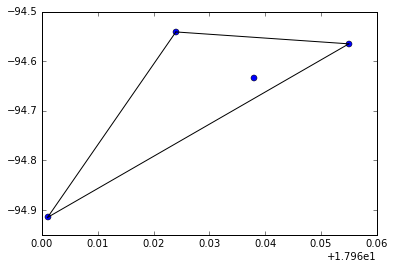

In [139]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in chull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [87]:
xy= matrix(rnorm(24, 100, 15), ncol=2)

NameError: name 'matrix' is not defined

In [83]:
test_table[test_table['AntennaID_2']==-1].head(10)

,Target,EXPOSED,AntennaID_0,count_0,AntennaID_1,count_1,AntennaID_2,count_2,AntennaID_3,count_3,...,count_5,AntennaID_6,count_6,AntennaID_7,count_7,AntennaID_8,count_8,AntennaID_9,count_9,EPIDEMIC
0,113241030,0,3715,24,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
2,113238925,0,4034,7,4023,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,113238845,1,29,4,160,3,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
5,113236935,0,2348,12,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
7,113235465,0,2724,7,1018,3,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
9,113234200,0,2839,15,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
11,113231845,0,4205,3,4198,2,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
12,113231795,0,1961,7,1706,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
14,113230980,0,1012,4,1779,3,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
15,113230190,0,3661,4,3860,2,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


In [37]:
type(antennas.columns)

pandas.core.index.Index

In [36]:
antennas[antennas.columns[]].loc[2]

pandas.core.series.Series

In [30]:
antennas.columns

Index([u'LATITUDE', u'LONGITUDE', u'STATE', u'EPIDEMIC'], dtype='object')

In [29]:
test_table =test_table.join(antennas[['LATITUDE','LONGITUDE']], on=='AntennaID_0')

,Target,EXPOSED,AntennaID_0,count_0,AntennaID_1,count_1,AntennaID_2,count_2,AntennaID_3,count_3,...,count_5,AntennaID_6,count_6,AntennaID_7,count_7,AntennaID_8,count_8,AntennaID_9,count_9,EPIDEMIC
0,113241030,0,3715,24,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,113240295,0,1082,4,942,1,3450,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
2,113238925,0,4034,7,4023,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,113238845,1,29,4,160,3,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,113238420,0,2138,9,1993,4,50,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


In [36]:
antennas.iloc[1]['LATITUDE']

14.682

In [20]:
output_file

'datosgeo/0315/Geo_Voz_Prepago_all_0315_test.txt.gz'

In [193]:
test_table.to_csv(output_file, index = True, 
                   header = True, mode='a',compression='gzip')

In [145]:
test_table_unique[test_table_unique['Target']==userid]

,Target,AntennaID_0,count_0,AntennaID_1,count_1,AntennaID_2,count_2,AntennaID_3,count_3,AntennaID_4,count_4,AntennaID_5,count_5,AntennaID_6,count_6,AntennaID_7,count_7,AntennaID_8,count_8
4875,4875,1289,6,321,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [153]:
test_table.head()

,Target,AntennaID,count
415314,112929298,1641,3
415313,112929298,1640,2
415315,112929298,2775,1
311537,112691397,191,5
311536,112561507,1713,5


In [154]:
antennas['EPIDEMIC'].head()

AntennaID
2797    1
3060    1
3344    1
3487    1
1924    1
Name: EPIDEMIC, dtype: int64

In [156]:
pd.merge?

In [146]:
test_table_unique.columns

Index([u'Target', u'AntennaID_0', u'count_0', u'AntennaID_1', u'count_1',
       u'AntennaID_2', u'count_2', u'AntennaID_3', u'count_3', u'AntennaID_4',
       u'count_4', u'AntennaID_5', u'count_5', u'AntennaID_6', u'count_6',
       u'AntennaID_7', u'count_7', u'AntennaID_8', u'count_8'],
      dtype='object')

In [87]:
grouped.sort_values(by=['Target','count'],ascending=True,inplace=True)

In [ ]:
bash_command = "zcat ./%s | head -n20" % test_file(output_file,num)
#os.system(bash_command)

In [156]:
test_table.head()

,Target,AntennaID,count
578331,93,257,1
771835,94,1358,4
578332,453,153,2
578333,533,911,1
1158533,626,4155,1


In [153]:
sample['Target'].value_counts().shape

(1185932,)

In [158]:
test_table['Target'].value_counts().shape

(1185932,)

In [126]:
test_table[test_table['Target']%10==1].shape

(20870, 3)

In [121]:
test_table.head(20)

,Target,AntennaID,count
96167,113239804,3104,1
78445,113229593,903,1
96166,113222784,1074,1
41305,113215661,2221,1
41304,113144521,3041,1
41303,113132241,521,1
96165,113099324,2774,1
20435,113087850,590,1
96164,113066214,804,2
41302,113064601,2331,1


In [45]:
antennas.shape

(4429, 4)

In [21]:
#enriquezco el dataset con la info de antennas_mexico.csv
enriched_sample = pd.merge(grouped,antennas[["EPIDEMIC","STATE"]],left_on="AntennaID",right_index=True)
#enriched_sample2 = pd.merge(sample2,antennas[["EPIDEMIC","STATE"]],left_on="AntennaID",right_index=True)aa

## Lo viejo:(20/12)
intentamos usar pandas para lograr este resultado y no reventaba la memoria del server para archivos de maximo 2GB (escribia el output file.. todo bien). Cuando GranData corrigio el simple_format los archivos se hicieron 4/5x veces mas grandes de tamanyo con lo cual pandas ya no aguantaba. Entonces pase a trabajar en c++ y usar pandas para corroborrar el resultadoe en archivos pequenyos.

In [64]:
enriched_sample.sort_values(by='TimeStamp',ascending=True,inplace=True)
enriched_sample2.sort_values(by='TimeStamp',ascending=True,inplace=True)

In [65]:
enriched_sample.head()

,Target,Destination,Direction,TimeStamp,Duration,AntennaID,EPIDEMIC,STATE
8971599,69192599,92013321,I,63158403,30,294,1,Hidalgo
12096070,94258325,71921565,O,63158404,14,897,1,Veracruz
3316840,1071787,70056182,I,63158405,63,668,1,Veracruz
6523154,4684133,70938133,O,63158410,214,1967,1,Jalisco
7334059,14804008,92958043,O,63158415,219,1623,1,Hidalgo


## Mobility
La idea es ahora mirar dentro de la base (prototipamos con sample) la lista de antenas utilizadas por cada usuario para obtener la variable dependiente $Y$ que vendria a ser si el tipo viajo o no por la zona endemica (visto como un llamado basicamente desde una antena en la epidemic zone). Despues buscaremos atributos, o variables regresoras que logren predecir ese comportamiento en el pasado pero usando solo los atributos en un timeframe "del futuro". Busco atributos que correlacionen con 'haber viajado por la zona endemica en el pasado'
#### pseudocode:
* tomamos el set de targets de la tabla.
* p/c/user lo mapeamos a un conjunto de antenas que sabemos que el tipo uso en algun CDR. Aca usamos alguna operacion groupby donde donde el key va a ser la columna target y la data a mirar es la AntennaID. Ahi extraemos la lista de antenas que el user uso. 
* descartamos del **monthly** dataset los users con "mal" uso, i.e. aquellos que su conjunto de antenas da menor que un threshold $ \beta$ (=5) y mayor que un limite (de 400) en este caso, que coresponderia a los users spammers/call-centers. Asi obtendremos una lista de usuarios de la telco que viajaron por mexico a partir de sus llamados en ese mes. Para eligir la cota superior basta con crear histogramas que muestren la funcion de distribucion para el ['Target']value_counts de los dataframes de llamados mensuales y ver que ya cualquier valor por encima de eso da un buen indicio de outlier/spammer.


In [6]:
#observar que el indice seria el target y el count seria el value de la serie
insignificant_users = tabla_mensual['Target'].value_counts()[(tabla_mensual['Target'].value_counts() <= 5) | (tabla_mensual['Target'].value_counts() >= 400)]
insignificant_users =  insignificant_users.index.values.tolist()
insignificant_users2 = tabla2_mensual['Target'].value_counts()[(tabla2_mensual['Target'].value_counts() <= 5) | (tabla2_mensual['Target'].value_counts() >= 400)]#insignificant_users2 =  insignificant_users2.index.values.tolist()

In [10]:
#me quedo con los CDRs que NO corresponden con estos targets
tabla_mensual = tabla_mensual[~tabla_mensual['Target'].isin(insignificant_users)]
tabla2_mensual = tabla2_mensual[~tabla2_mensual['Target'].isin(insignificant_users2)]

In [11]:
#con esto extraigo el mapping user --> antennas used that month
user_antenna_map2 = tabla2_mensual.groupby('Target')['AntennaID'].apply(lambda x: x.tolist()).to_dict();
user_antenna_map = tabla_mensual.groupby('Target')['AntennaID'].apply(lambda x: x.tolist()).to_dict();


In [12]:
#hago unos testeos a mano para ver si levanto bien lo que queriamos.. i.e. si guardo todas las antenas de un user para c/CDR
user_antenna_map[1546770]

[331, 99, 686, 100, 99, 686, 100, 861, 99, 79, 79, 861, 219, 624, 686, 686]

In [13]:
tabla_mensual[tabla_mensual['Target']==1546770]

,Target,Destination,Direction,TimeStamp,Duration,AntennaID
4244460,1546770,71541497,I,63240962,27,331
4244461,1546770,69908764,O,65262492,28,99
4244462,1546770,93291721,O,65270682,105,686
4244463,1546770,93291721,I,65272482,66,100
4244464,1546770,70088843,O,65285078,149,99
4244465,1546770,94419977,I,65375387,44,686
4244466,1546770,94419977,O,65380705,64,100
4244467,1546770,70088843,O,65387679,29,861
4244468,1546770,93291767,O,65391085,20,99
14260114,1546770,93291767,O,64073590,47,79


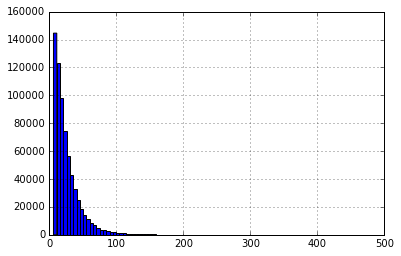

In [14]:
#para observar la distribucion de veces que un usuario llama en un mes.
tabla_mensual['Target'].value_counts().hist(bins=100)

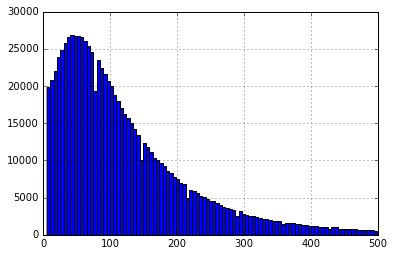

In [15]:
tabla2_mensual['Target'].value_counts().hist(bins=100)

In [2]:
!du -ha datosgeo/0415/Geo*

0	datosgeo/0415/Geo_Voz_Pospago_all_0415.txt.gz
1.4G	datosgeo/0415/Geo_Voz_Prepago_all_0415.txt.gz


## Cuidado!
* como el comando "head" lee lineas. y el json file es toda una linea (no guardo '\n' en ningun lado) si yo pido head asi nomas rompo el notebook y tengo que resetear firefox
* NO se puede usar JSON para guardar un dict de "ints" porque convierte todo a strings y despues no se puede volver a recuperar el type pues lee todo como un gran unicode list. Usar cPickle ^^  ...hasta pandas lo levanta. El unico problema es que cuando abris un .p como texto no es human readable..

In [ ]:
with open('test_data.p', 'wb') as fp:
    pickle.dump(user_antenna_map, fp)

with open('test_data.p', 'rb') as fp:
    data = pickle.load(fp)

In [ ]:
##este script es muy pesado en memoria para el tamanyo del dataset.. no se va a poder usar
#rootdir = '/home/juan/mobility-study/datosgeo'
#os.chdir(rootdir)
#directory = "0415"
#tabla_mensual = pd.read_csv(directory +'/Geo_Voz_Prepago_all_' + directory + '.txt.gz',sep = " ", 
 #             names = ['Target','Destination','Direction','TimeStamp','Duration','AntennaID'],
#                        engine = 'c',index_col=None, lineterminator='\n', skipinitialspace=True, 
#                    header=None,dtype = {'Target':np.int32,'Destination':np.uint32,'TimeStamp':np.uint32,
#                                      'Duration':np.uint16,'AntennaID':np.uint16,'Direction':np.object_})
#insignificant_users = tabla_mensual['Target'].value_counts()[(tabla_mensual['Target'].value_counts() <= 5) \
#                    | (tabla_mensual['Target'].value_counts() >= 400)].index.values.tolist()

## tal vez habria que ver de probar rosetta aca para ver si podemos aprovechar la paralelizacion

#filtro los usuarios irrelevantes y armo el diccionario con key= users, values = antenna_list    
tabla_mensual= tabla_mensual[~tabla_mensual['Target'].isin(insignificant_users)] 
user_antenna_map = tabla_mensual.groupby('Target')['AntennaID']
user_antenna_map = user_antenna_map.apply(lambda x: x.tolist()).to_dict();
del tabla_mensual; del insignificant_users

with open(directory + "/" + 'Geo_Voz_Prepago_user-antenna-map_' + directory +'.p', 'wb') as fp:
    pickle.dump(user_antenna_map, fp)

del user_antenna_map

## Lo nuevo (20/12)
primero creo un script en c++ que asigna antennas a usuarios que tengan un call_count mensual de mas de 5 y menos de 400.
Para elegir la antenna considero basicamente la que mas usa. Y si hay empate, toma la antennaID que utilizo primero... (despues se ampliara). Con pandas la idea es chequear que este funcionando correctamente el codigo.

In [3]:
!du -ha datosgeo/0315/Geo*

0	datosgeo/0315/Geo_Voz_Pospago_all_0315.txt.gz
1.3G	datosgeo/0315/Geo_Voz_Prepago_all_0315.txt.gz


In [4]:
rootdir="/home/juan/mobility-study"
os.chdir(rootdir)
directory = "0315"; contract_type="Prepago";
tabla_mensual = pd.read_csv('datosgeo/%s/Geo_Voz_%s_all_%s.txt.gz' % (directory,contract_type,directory),sep = " ", 
              names = ['Target','Destination','Direction','TimeStamp','Duration','AntennaID'],
                             engine = 'c',index_col=None, lineterminator='\n', skipinitialspace=True, 
                    header=None,dtype = {'Target':np.int32,'Destination':np.uint32,'TimeStamp':np.uint32,
                                      'Duration':np.uint16,'AntennaID':np.uint16,'Direction':np.object_})

In [ ]:
a=0

In [5]:
#tomamos un sample de 6 millones de usuarios
sample =  tabla_mensual.sample(6*10**6)

In [ ]:
directory,contract_type

In [ ]:
#guardamos en el rootdir para trabajar sobre archivos mas chico
sample.to_csv('datosgeo/%s/Geo_Voz_%s_all_%s_sample.txt.gz' % (directory,contract_type,directory),sep=" ", header = False,
              index = False, encoding = 'utf-8', compression = 'gzip')

In [3]:
rootdir="/home/juan/mobility-study"
os.chdir(rootdir)
directory = "0315"; contract_type="Pospago";
tabla_mensual = pd.read_csv('datosgeotest/%s/Geo_Voz_%s_all_%s.txt.gz' % (directory,contract_type,directory),sep = " ", 
              names = ['Target','Destination','Direction','TimeStamp','Duration','AntennaID'],
                             engine = 'c',index_col=None, lineterminator='\n', skipinitialspace=True, 
                    header=None,dtype = {'Target':np.int32,'Destination':np.uint32,'TimeStamp':np.uint32,
                                      'Duration':np.uint16,'AntennaID':np.uint16,'Direction':np.object_})
tabla_mensual['TimeStamp'] =  (tabla_mensual.TimeStamp.values*1.0/3600)%24

insignificant_users = tabla_mensual['Target'].value_counts()[(tabla_mensual['Target'].value_counts() < 5) \
                    | (tabla_mensual['Target'].value_counts() > 400)].index.values.tolist()
tabla_mensual= tabla_mensual.loc[~tabla_mensual['Target'].isin(insignificant_users),['Target','TimeStamp','AntennaID']]

del insignificant_users

In [76]:
#OBS.: es importante volver a hacer el "refiltrado" de insignificant users pues al aplicar nightfilter tire varios 
## llamados, y al hacer esto tal vez un usuario que antes tenia 10 llamados pre filtrado, ahora tiene 3 llamados postfiltrado

tabla_mensual_nightfilter = tabla_mensual.loc[(tabla_mensual['TimeStamp']<8) | (tabla_mensual['TimeStamp']>18)]

insignificant_users_nightfilter = tabla_mensual_nightfilter['Target'].value_counts()[(tabla_mensual_nightfilter['Target'].value_counts() < 5) \
                    | (tabla_mensual_nightfilter['Target'].value_counts() > 400)].index.values.tolist()
tabla_mensual_nightfilter= tabla_mensual_nightfilter.loc[~tabla_mensual_nightfilter['Target'].isin(insignificant_users_nightfilter),['Target','TimeStamp','AntennaID']]
del insignificant_users_nightfilter

In [152]:
tabla_mensual.shape ,tabla_mensual_nightfilter.shape

((17813896, 3), (5915607, 3))

In [6]:
#defino la funcion que asigna antenas a los users.
def first_max_antenna(x):
    sol = -1
    a= x.tolist()
    if not(len(a)<5 or len (a)>400):
        sol = max(set(a), key=a.count)
    
    return sol


In [162]:
cpp_user_antenna_map = pd.read_csv('./datosgeotest/%s/user_antenna_map/user_antenna_map_%s_%s.txt.gz' % (directory,contract_type,directory),
                                   sep = "|",names = ['Target','AntennaID'], engine = 'c',index_col='Target', 
                                   lineterminator='\n', skipinitialspace=True,skiprows=1,
                    header=None,dtype = {'Target':np.int32,'AntennaID':np.int16})

cpp_user_antenna_map_nightfilter = pd.read_csv('./datosgeotest/%s/user_antenna_map/user_antenna_map_%s_%s_nightfilter.txt.gz' % (directory,contract_type,directory),sep = "|", 
              names = ['Target','AntennaID'],
                             engine = 'c',index_col='Target', lineterminator='\n', skipinitialspace=True,skiprows=1,
                    header=None,dtype = {'Target':np.int32,'AntennaID':np.int16})

In [79]:
user_antenna_map_nightfilter = tabla_mensual_nightfilter.groupby('Target')['AntennaID'].apply(lambda x: first_max_antenna(x))

In [80]:
user_antenna_map = tabla_mensual.groupby('Target')['AntennaID'].apply(lambda x: first_max_antenna(x))

In [163]:
len(user_antenna_map),len(cpp_user_antenna_map), len(user_antenna_map_nightfilter),len(cpp_user_antenna_map_nightfilter)

(715183, 444177, 444083, 444177)

In [82]:
sum(user_antenna_map!=-1),sum(cpp_user_antenna_map['AntennaID']!=-1),sum(user_antenna_map_nightfilter!=-1),sum(cpp_user_antenna_map_nightfilter['AntennaID']!=-1)

(715183, 715183, 444083, 444177)

Voy chequeando a mano: La idea es imprimir algun todos los usuario del cpp que NO esten asignados de igual forma en el user_antenna_map y chequear a mano el grupo de este tipo. 

Tambien hay un problema con el nightfilter y el operador de division entera '/' que *pisa* todos los decimales y no funciona igual que en c++, por eso la diferencia de usuarios que "entran" como de noche y los que no. 

In [12]:
grouped_users = tabla_mensual.groupby('Target')['AntennaID']

In [13]:
#con esto chequeo todos los que sean distintos, pidiendole la serie a cpp_user_antenna_map
user_antenna_map[cpp_user_antenna_map.ix[:,0]!=user_antenna_map]

Target
418          185
532          232
603          272
765          345
816          371
868          422
1221         628
1243          35
1435         444
1488          69
1547         341
1567         488
1778         163
2079         235
2116        1898
2124         353
2189          34
2217         100
2274          33
2388         337
2611        1033
2725         557
2748         966
2807         803
2861         544
3111         688
3192          40
3372         220
3438         376
3448        1582
3516         293
3527         329
3587        1080
4122         224
4245         115
4247         175
4250         832
4422          35
4622         877
4776         344
4864         809
5024         650
5116         358
5400          77
5420         495
5494        1376
5754        1128
5776         225
5782         225
6099         456
6338         321
6438         228
6523         457
6745         886
6755         572
6817         873
6996         166
7093         614
7115   

In [57]:
distinto = 14286
#mirando la lista de agrupados con get_group hago un conteo de las antenas que aparecen con value_counts() para ver cuales
#estan bien catalogadas y cuales no
print "los conteos de antenas son \n"
print grouped_users.get_group(distinto).value_counts()

print "la que selecciona pandas es " + str(max(set(grouped_users.get_group(distinto).tolist()),key=grouped_users.get_group(distinto).tolist().count))
print "la que selecciona el script cpp es %s" % str(cpp_user_antenna_map.ix[distinto]).split()[1]

los conteos de antenas son 

1343    5
338     5
1997    3
585     2
Name: AntennaID, dtype: int64
la que selecciona pandas es 338
la que selecciona el script cpp es 2985


In [17]:
len(user_antenna_map[cpp_user_antenna_map.ix[:,0]!=user_antenna_map]), len(user_antenna_map[cpp_user_antenna_map.ix[:,0]!=user_antenna_map])*1.0/len(user_antenna_map)

(35992, 0.05032558100514134)

Hast ahora el problema de las diferencias entre el cpp y el pandas (sin filtro) es para casos de empate en el count de antennas. Por el cual ahi la asignacion es distinta en cada caso, sin embargo esta diferencia es para muy pocos usuarios (menos de 3% segun la cuenta de la celda anterior)

## Ahora miro las diferencias en el script con el *nightfilter*

In [83]:
len(cpp_user_antenna_map_nightfilter),len(user_antenna_map_nightfilter)

(444177, 444083)

In [88]:
grouped_users_nightfilter = tabla_mensual_nightfilter.groupby('Target')['AntennaID']

444177

In [115]:
#np.in1d(array1,array2) devuelve un array de bools de largo array1 que dice si el elemento ese de array1 esta en array2
cpp_user_antenna_map_nightfilter[~np.in1d(cpp_user_antenna_map_nightfilter.index.values, user_antenna_map_nightfilter.index.values)]


,AntennaID
Target,
33501,903
36587,795
43002,415
60683,358
62385,3945
62387,1493
113897,1696
148338,1573
152376,1397


In [160]:
usuario_problema = 70834276

cpp_user_antenna_map_nightfilter.ix[usuario_problema]

AntennaID    1344
Name: 70834276, dtype: int16

In [161]:
cpp_user_antenna_map[cpp_user_antenna_map.index.values== usuario_problema]

,AntennaID
Target,


In [151]:
tabla_mensual[tabla_mensual['Target']== usuario_problema]

,Target,TimeStamp,AntennaID


In [69]:

print "los conteos de antenas son \n"
print grouped_users_nightfilter.get_group(usuario_problema).value_counts()

print "la que selecciona pandas es " + str(max(set(grouped_users_nightfilter.get_group(usuario_problema).tolist()), \
                                               key=grouped_users_nightfilter.get_group(usuario_problema).tolist().count))
print "la que selecciona el script cpp es %s" %  str(cpp_user_antenna_map_nightfilter.ix[usuario_problema]).split()[1]


#mirando la lista de agrupados con get_group hago un conteo de las antenas que aparecen con value_counts() para ver cuales
#estan bien catalogadas y cuales no


los conteos de antenas son 



KeyError: 6

,Target,TimeStamp,AntennaID


In [44]:
max(set(grouped_users_nightfilter.get_group(usuario_problema).tolist()),key=grouped_users_nightfilter.get_group(usuario_problema).tolist().count)

2624

In [45]:
cpp_user_antenna_map_nightfilter.ix[usuario_problema]

KeyError: 400